In [99]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import copy
from collections import Counter

# Import hex maze functions
from hex_maze.hex_maze_utils import plot_hex_maze, divide_into_thirds, get_critical_choice_points, get_hexes_within_distance, get_hexes_from_port

### Define all of our functions here for now so we can see everything

Functions for loading things

In [31]:
def reduce_df_mem_usage(df, print_mem_usage=True):
    ''' 
    Given a DataFrame, return an optimized DataFrame that uses less memory. 
    
    Args:
    df (DataFrame): The DataFrame to optimize
    print_mem_usage (bool): Optional. Print the memory usage of the
    DataFrame before and after optimization. Defaults to True

    Returns:
    DataFrame: memory-optimized version of the original DataFrame
    '''
    start_mem = df.memory_usage().sum() / 1024**2
    if (print_mem_usage):
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    if (print_mem_usage):
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))  
    return df


def add_total_trials_to_df(df):
    '''
    Add a total_trials column to the DataFrame enumerating
    each time the 'tri' column changes. This is useful to 
    track trials for DataFrames that combine multiple sessions. 
    
    This should be run on DataFrames that have been cleaned with
    clean_session_dfs to avoud counting the "trials" of <10 samples
    that occur directly before a block changes 

    Args:
    df (DataFrame): Combined DataFrame for multiple rats/sessions

    Returns:
    DataFrame: The DataFrame with a total_trials column added
    '''
    # Find each time a trial changes
    trial_ends = df.index[df['tri'] != df['tri'].shift()][1:].tolist()
    # Make sure to include the end of the DataFrame as the last trial end
    trial_ends.append(df.index[-1])
    # Enumerate each trial at the trial end index in a new column 'total_trials'
    df.loc[trial_ends, 'total_trials'] = range(sum(trial_ends))
    # Backfill each trial number from the trial end point
    df['total_trials'] = df['total_trials'].astype(float).bfill()
    return df


def clean_session_df(df, print_info=True):
    '''
    Clean the DataFrame for a session. Removes extra samples after the last
    valid trial (trial with a port entry) of the session. Also ensures that
    trial changes are aligned with block changes, removing misaligned "trials"
    of <10 samples directly before a block change. These samples will be reassigned
    to the previous trial.

    Args:
    df (DataFrame): A dataframe for a single session
    print_info (bool): Optional. Prints info about the cleaning being done.
    Defaults to True

    Returns:
    DataFrame: a cleaned version of the dataframe where each trial has exactly
    one port entry
    '''
    # Step 1: remove the extra samples after the last valid trial of the session.
    # The last valid trial is the last trial with a port entry.

    # Find the index of the last port entry in this session
    last_port_entry_idx = df[df['port'] != -100].index[-1]
    # Find which trial this occurs in
    last_valid_trial = df.loc[last_port_entry_idx, 'tri']
    # Find the end index of this trial
    df_after_last_entry = df.loc[last_port_entry_idx:]
    last_valid_trial_end = df_after_last_entry.index[df_after_last_entry['tri'] != last_valid_trial][0]

    if print_info:
        print(f"The last port entry in this session occured at index {last_port_entry_idx} in trial {int(last_valid_trial)}.")
        print(f"This trial ended at index {last_valid_trial_end}.")
        print(f"The dataframe ends at index {len(df)}. Removing the last {len(df)-last_valid_trial_end} samples ({(len(df)-last_valid_trial_end)/250} seconds)\n")

    # Remove the extra samples after the last valid trial
    clean_df = df.loc[:last_valid_trial_end - 1]

    # Step 2: Adjust the last residual trial in each block to ensure all trials 
    # have a port entry 

    # Find where the blocks change
    block_change_indices = clean_df.index[clean_df['block'] != clean_df['block'].shift()][1:].tolist()
    if print_info:
        print(f"The blocks change at indices: {block_change_indices}")
    trial_change_indices = clean_df.index[clean_df['tri'] != clean_df['tri'].shift()][1:].tolist()

    for block_num, block_change in enumerate(block_change_indices, start=1):
        # Find the index of the last trial change before the block change
        tri_change_before_block = max((idx for idx in trial_change_indices if idx < block_change), default=None)
        if print_info:
            print(f"For the block ending at index {block_change}, the last trial change in this block is at index {tri_change_before_block}")
    
        # Find the number of this trial
        trial_num = clean_df.loc[tri_change_before_block, 'tri']
        # Find the indices of this trial
        last_trial_indices = clean_df[(clean_df['block'] == block_num) & 
                                      (clean_df['tri'] == trial_num)].index
        if print_info:
            print(f"Trial {trial_num} at the end of block {block_num} spans {len(last_trial_indices)} indices ({len(last_trial_indices)/250} seconds):")
            print(last_trial_indices)
            print(f"These indices are being reassigned to the end of trial {trial_num-1}\n")

        # Reassign the last few indices to the previous trial
        if (len(last_trial_indices) <=250):
            clean_df.loc[last_trial_indices, 'tri'] = trial_num-1
        else:
            # Non-optional warn just in case
            print("Reassigning over 1 second of data - double check this is not a legitimate trial!! \n")
    
    return clean_df


def load_session_dfs(session_dict, directory='/Volumes/Tim/Ephys'):
    '''
    Load all DataFrames for the specified sessions.
    Ensure position data has been interpolated and hexlabels have
    been filled between missing camera frames.
    Adds a total_trials column enumerating trials across all sessions.

    Args:
    session_dict (dict): Dictionary specifying the sessions to load, 
    where the keys are rats and the values are dates
    directory (string): The base directory prefix to load from. 
    The assumed directory structure is {directory}/{rat}/{date}/etc,
    where the rats and dates are specified by session_dict

    Returns:
    Dataframe: A combined DataFrame for all specified rats and dates.
    '''
    all_dataframes = []
    session = 1
    for rat in session_dict:
        for date in session_dict[rat]:
            # Load dataframe and add column identifying this session
            session_df = attempt_df_load(rat, date, directory)
            session_df["session"] = session
            # Ensure that position data has been interpolated
            session_df["x"] = session_df["x"].interpolate()
            session_df["y"] = session_df["y"].interpolate()
            # Ensure hexlabels have been filled between missing camera frames
            # (replace -1 with NaN so we can use ffill to forward fill the hex labels)
            session_df["hexlabels"] = session_df["hexlabels"].replace(-1, np.nan)
            session_df["hexlabels"] = session_df["hexlabels"].astype(float).ffill()
            # Make sure all trials are valid and aligned
            cleaned_session_df = clean_session_df(session_df, True)
            # Add this session to our list of dataframes
            all_dataframes.append(cleaned_session_df)
            session += 1
    # Combine all session dataframes into a single dataframe
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    # Add a total_trials column enumerating trials across all sessions
    #print("done loading")
    #combined_df = add_total_trials_to_df(combined_df)
    return combined_df


def attempt_df_load(rat, date, directory='/Volumes/Tim/Ephys'):
    '''
    Attempt to load a DataFrame for the given rat and date.
    The assumed directory structure is {directory}/{rat}/{date}/etc
    Complain if the load fails. 

    Args:
    rat (string): The ID of the rat
    date (string): The date to load, in MMDDYYYY format
    directory (string): The base directory to load from

    Returns:
    new_df (DataFrame): The loaded Dataframe, or None if the load failed
    '''
    try:
        df_path = f"{directory}/{rat}/{date}/phot_decode_df_withHexStates.csv"
        new_df = reduce_df_mem_usage(pd.read_csv(df_path))
        return new_df
    except:
        print(f"Could not load df for {rat}; {date}")
        print(f"Attempted load path was: {df_path}")


def attempt_load_barriers(rat, date, directory='/Volumes/Tim/Photometry'):
    '''
    Attempt to load a list of barriers for the given rat and date.
    The assumed directory structure is {directory}/{rat}/{date}/etc
    Complain if the load fails. 

    Args: 
    rat (string): The ID of the rat
    date (string): The date to load, in MMDDYYYY format
    directory (string): The base directory to load from

    Returns:
    barrier_sequence (list of sets): List of barrier sets used in this session,
    or an empty list if the load failed
    '''
    barrier_sequence = []
    try:
        barriers_path = f"{directory}/{rat}/{date}/barriers.txt"
        # Read from the text file and append each set to the list
        with open(barriers_path, 'r') as txtfile:
            for line in txtfile:
                # Ignore any empty lines or lines starting with '#'
                if line.strip().startswith('#') or not line.strip():
                    continue
                # Strip any leading/trailing whitespace and split by commas
                barriers_string = line.strip().split(',')
                # Convert each number to an integer and create a set
                barrier_set = set(map(int, barriers_string))
                barrier_sequence.append(barrier_set)
            return barrier_sequence
    except:
        print(f"Could not load barriers for {rat}; {date}")
        print(f"Attempted load path was: {barriers_path}")
        return []


def nested_dict_to_df(nested_dict, metadata=True):
    '''
    Make our nested dictionary nexted_dict[session][block][trial] into a dataframe.
    Option to include or exclude session and block-level metadata.

    Args:
    nested_dict (dict): Nested dictionary of trial-level data in the format
    nested_dict[session][block][trial], with session and block-level metadata 
    nested_dict[session]['metadata'] and nested_dict[sesison][block]['metadata']
    metadata (bool): If we should include metadata info as columns in our new dataframe.
    Defaults to True

    Returns:
    DataFrame: the dictionary flattened into a DataFrame    
    '''

    # Set up list to flatten the nested dict
    flattened_data = []

    # Create copy of the dict so we can pop
    copied_dict = copy.deepcopy(nested_dict)

    # Iterate through sessions, blocks, and trials
    for session_key, session_data in copied_dict.items():
        session_metadata = session_data.pop('metadata', {})
        for block_key, block_data in session_data.items():
            block_metadata = block_data.pop('metadata', {})
            for trial_key, trial_data in block_data.items():
                # Add info for each trial
                row = {
                    'session': int(session_key),
                    'block': int(block_key),
                    'trial': int(trial_key),
                    **trial_data
                }
                # Add session and block-level metadata
                if metadata:
                    row.update(session_metadata)
                    row.update(block_metadata)
                flattened_data.append(row)
    return(pd.DataFrame(flattened_data))


def remove_consecutive_duplicates(input_list):
    ''' Helper function to remove consecutive duplicate values in a list. '''
    return [input_list[i] for i in range(len(input_list)) if i == 0 or input_list[i] != input_list[i-1]]


In [3]:
# These are the 10 sessions used in Tim's poster
sesh_dict = {"IM-1478":["07192022", "07202022", "07242022", "07252022", "07262022", "07272022"],
             "IM-1594":["07252023", "07262023", "07272023", "07282023"]}
ephys_directory = '/Volumes/Tim/Ephys'
            
# Load dataframes for these sessions into a combined df
df = load_session_dfs(sesh_dict, directory=ephys_directory)

Memory usage of dataframe is 534.37 MB
Memory usage after optimization is: 125.24 MB
Decreased by 76.6%
The last port entry in this session occured at index 1729655 in trial 57.
This trial ended at index 1729767.
The dataframe ends at index 1751025. Removing the last 21258 samples (85.032 seconds)

The blocks change at indices: [450737, 1078884]
For the block ending at index 450737, the last trial change in this block is at index 450731
Trial 65 at the end of block 1 spans 6 indices (0.024 seconds):
Index([450731, 450732, 450733, 450734, 450735, 450736], dtype='int64')
These indices are being reassigned to the end of trial 64

For the block ending at index 1078884, the last trial change in this block is at index 1078876
Trial 62 at the end of block 2 spans 8 indices (0.032 seconds):
Index([1078876, 1078877, 1078878, 1078879, 1078880, 1078881, 1078882, 1078883], dtype='int64')
These indices are being reassigned to the end of trial 61

Memory usage of dataframe is 522.47 MB
Memory usage 

Maze configs for IM-1478/07192022:


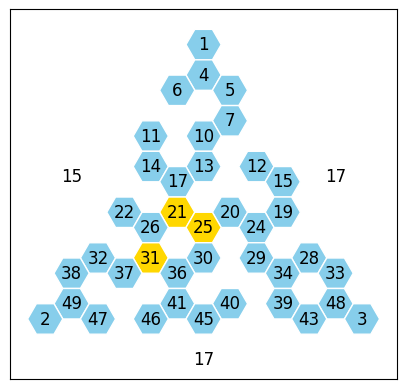

{35, 8, 9, 42, 44, 16, 18, 23, 27}


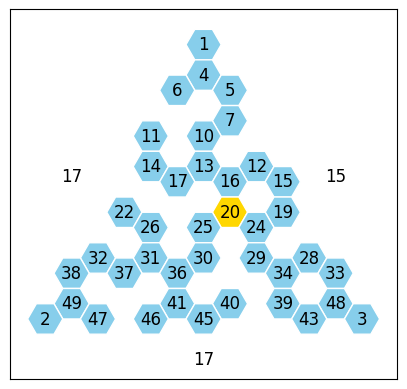

{35, 8, 9, 42, 44, 18, 21, 23, 27}


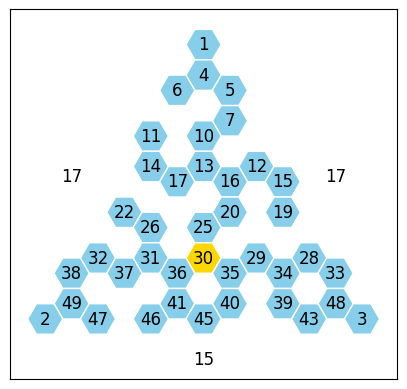

{8, 9, 42, 44, 18, 21, 23, 24, 27}
Maze configs for IM-1478/07202022:


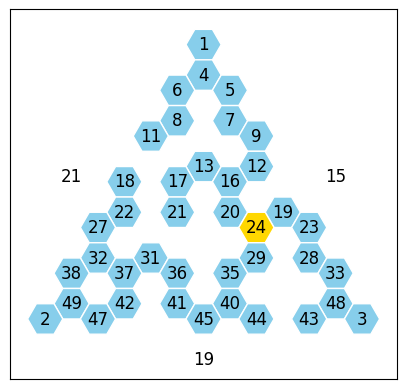

{34, 39, 10, 14, 15, 46, 25, 26, 30}


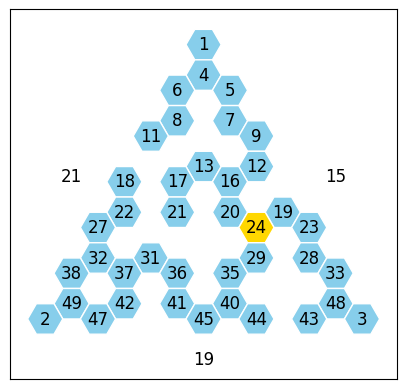

{34, 39, 10, 14, 15, 46, 25, 26, 30}
Maze configs for IM-1478/07242022:


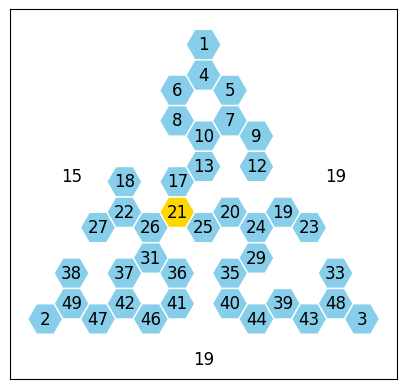

{32, 34, 11, 45, 14, 15, 16, 28, 30}


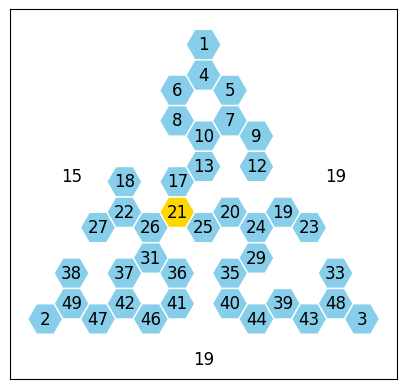

{32, 34, 11, 45, 14, 15, 16, 28, 30}
Maze configs for IM-1478/07252022:


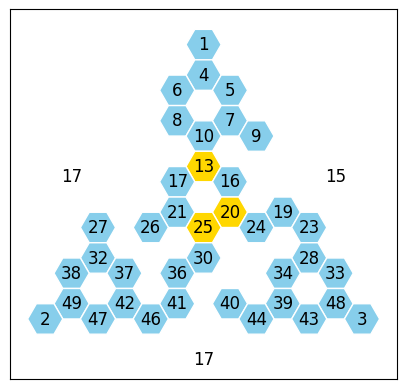

{35, 11, 12, 45, 14, 15, 18, 22, 29, 31}


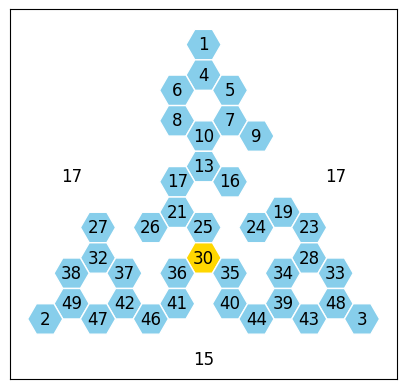

{11, 12, 45, 14, 15, 18, 20, 22, 29, 31}


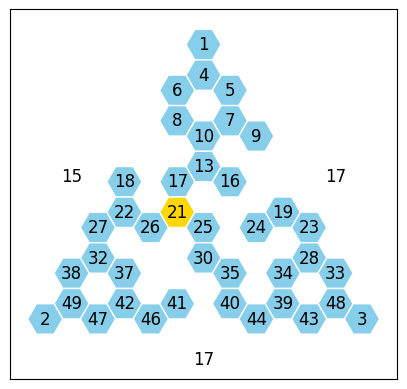

{36, 11, 12, 45, 14, 15, 20, 29, 31}
Maze configs for IM-1478/07262022:


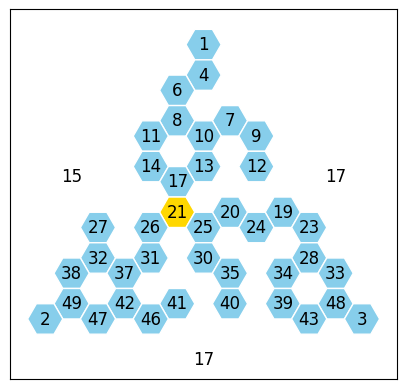

{36, 5, 44, 45, 15, 16, 18, 22, 29}


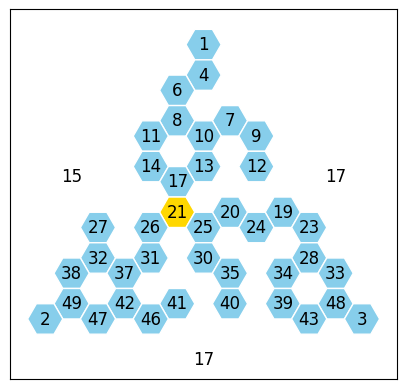

{36, 5, 44, 45, 15, 16, 18, 22, 29}


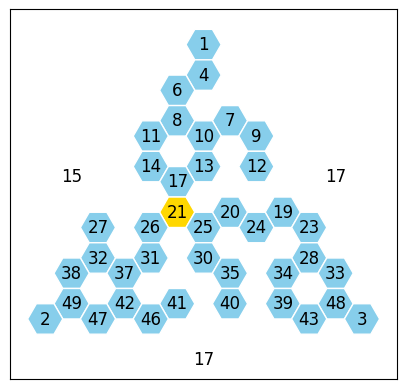

{36, 5, 44, 45, 15, 16, 18, 22, 29}
Maze configs for IM-1478/07272022:


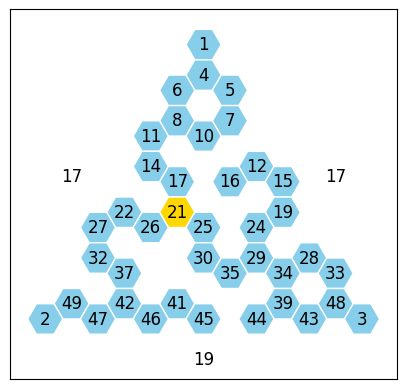

{36, 38, 40, 9, 13, 18, 20, 23, 31}


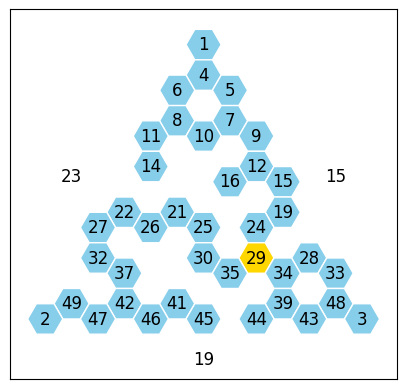

{36, 38, 40, 13, 17, 18, 20, 23, 31}


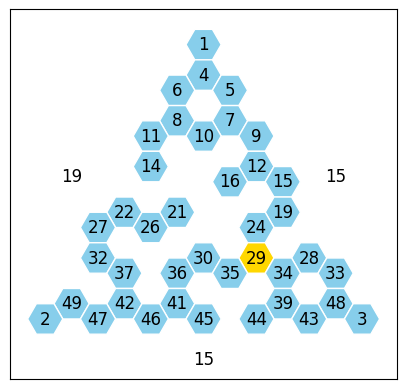

{38, 40, 13, 17, 18, 20, 23, 25, 31}


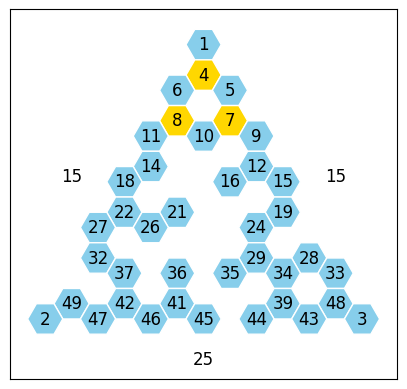

{38, 40, 13, 17, 20, 23, 25, 30, 31}
Maze configs for IM-1594/07252023:


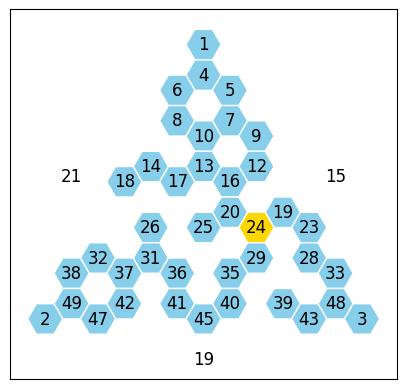

{34, 11, 44, 46, 15, 21, 22, 27, 30}


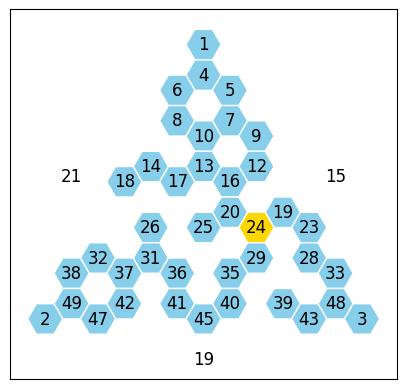

{34, 11, 44, 46, 15, 21, 22, 27, 30}


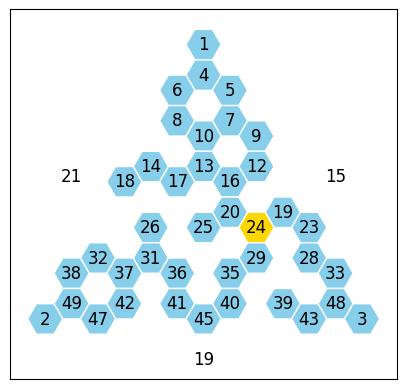

{34, 11, 44, 46, 15, 21, 22, 27, 30}
Maze configs for IM-1594/07262023:


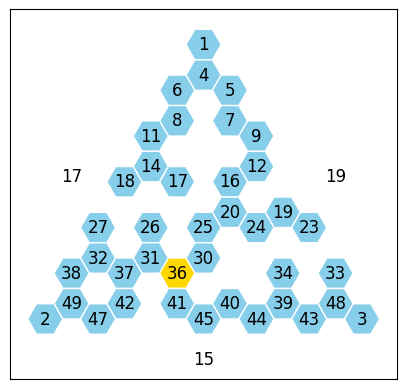

{35, 10, 13, 46, 15, 21, 22, 28, 29}


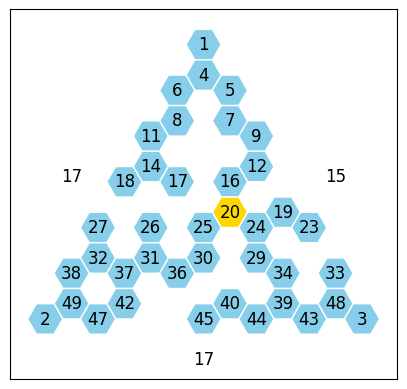

{35, 41, 10, 13, 46, 15, 21, 22, 28}


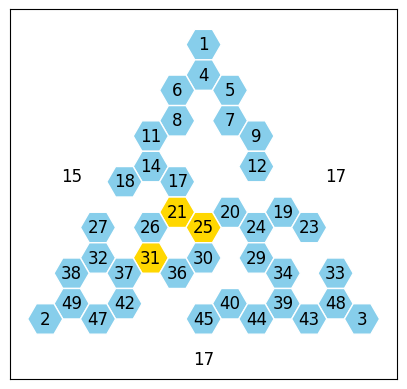

{35, 41, 10, 13, 46, 15, 16, 22, 28}


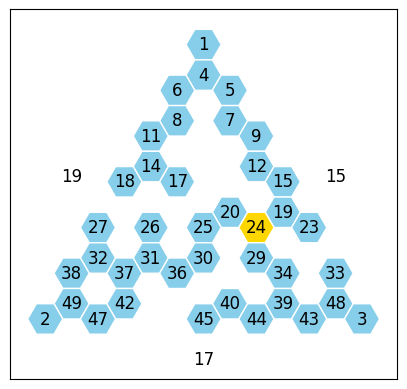

{35, 41, 10, 13, 46, 16, 21, 22, 28}


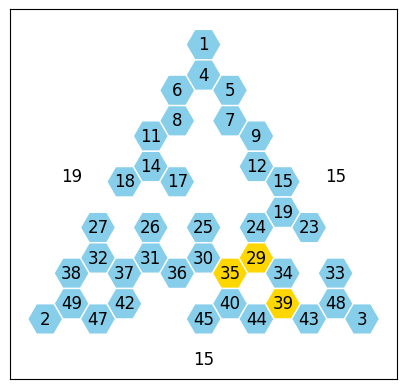

{41, 10, 13, 46, 16, 20, 21, 22, 28}
Maze configs for IM-1594/07272023:


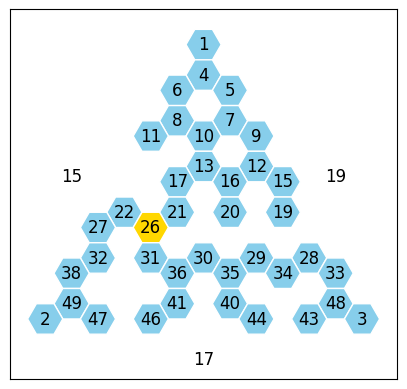

{37, 39, 42, 45, 14, 18, 23, 24, 25}


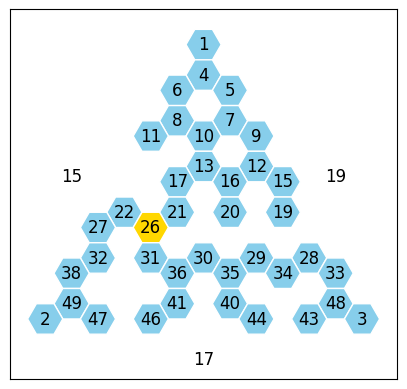

{37, 39, 42, 45, 14, 18, 23, 24, 25}


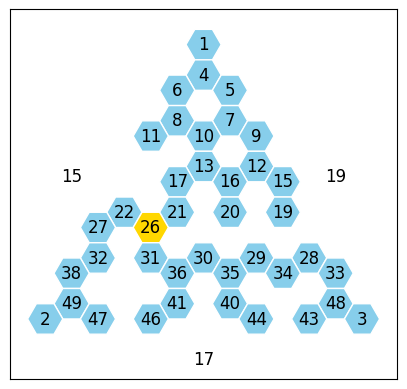

{37, 39, 42, 45, 14, 18, 23, 24, 25}
Maze configs for IM-1594/07282023:


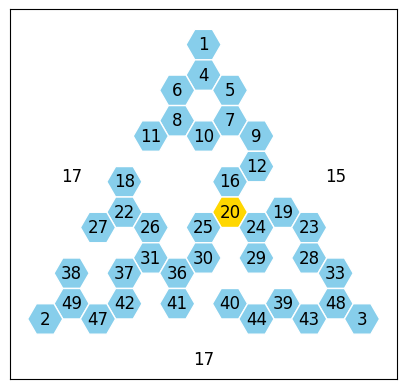

{32, 34, 35, 13, 14, 15, 46, 17, 45, 21}


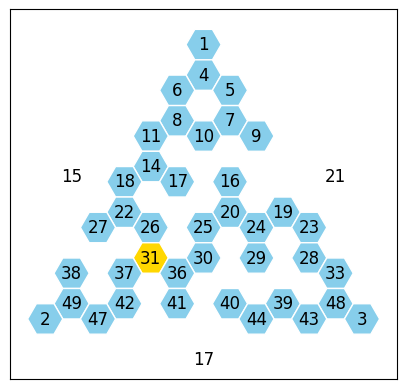

{32, 34, 35, 12, 13, 46, 15, 45, 21}


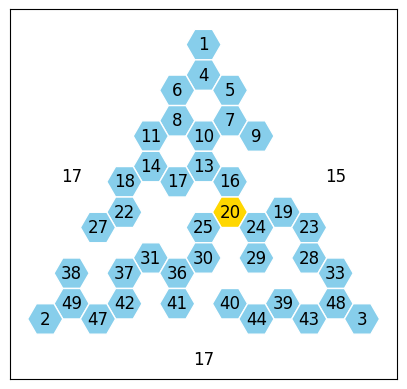

{32, 34, 35, 12, 45, 46, 15, 21, 26}


In [156]:
#  I want to see what all of the mazes Tim used look like 
# -> How many have a single choice point / can be easily divided into thirds?

for rat in sesh_dict:
    for date in sesh_dict[rat]:
        # Load the maze config(s) for this session
        barrier_sequence = attempt_load_barriers(rat, date)
        print(f"Maze configs for {rat}/{date}:")
        for maze in barrier_sequence:
            plot_hex_maze(maze, show_barriers=False, show_stats=True)
            print(maze)

In [5]:
# Add a total_trials column to the dataframe

# Find each time a trial changes
tri_array = df['tri'].to_numpy()
# Find where the value changes
trial_changes = np.where(tri_array[:-1] != tri_array[1:])[0] + 1
# Convert the result to a list and slice as needed
trial_ends = trial_changes.tolist()
# Make sure to include the end of the dataframe as the last trial end
trial_ends.append(df.index[-1])
print(f"There are {len(trial_ends)} trials in this dataframe")
# Enumerate each trial at the trial end index in a new column 'total_trials'
df.loc[trial_ends, 'total_trials'] = range(1, len(trial_ends) + 1)
# Backfill each trial number from the trial end point
df['total_trials'] = df['total_trials'].astype(float).bfill()

display(df)

There are 1681 trials in this dataframe


/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Unnamed: 0,index,green_z_scored,port,rwd,x,y,nom_rwd_a,nom_rwd_b,beamA,...,frame,ref,fromP,470,nextprob,nextp,simple_rr,pchosen,Unnamed: 0.2,total_trials
0,0,81873601,1.759766,-100,0,324.500,53.65625,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,81873602,1.776367,-100,0,324.500,53.71875,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,81873603,1.774414,-100,0,324.500,53.81250,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,3,81873604,1.750000,-100,0,324.500,53.87500,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,4,81873605,1.703125,-100,0,324.500,53.93750,90.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590315,1779762,1779762,-1.080078,-100,0,146.500,85.31250,50.0,10.0,0.0,...,1779753.0,0.507324,1.0,1242902.500,10.0,1.0,0.0,NaN,1774121.0,1681.0
15590316,1779763,1779763,-1.120117,-100,0,146.625,85.31250,50.0,10.0,0.0,...,1779753.0,0.551270,1.0,1242789.125,10.0,1.0,0.0,NaN,1774122.0,1681.0
15590317,1779764,1779764,-1.178711,-100,0,146.625,85.31250,50.0,10.0,0.0,...,1779753.0,0.643066,1.0,1242447.875,10.0,1.0,0.0,NaN,1774123.0,1681.0
15590318,1779765,1779765,-1.249023,-100,0,146.750,85.25000,50.0,10.0,0.0,...,1779753.0,0.746582,1.0,1241972.375,10.0,1.0,0.0,NaN,1774124.0,1681.0


In [6]:
print(df.columns)

# Drop useless columns
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2']
df = df.drop(columns=columns_to_drop)


Index(['Unnamed: 0', 'index', 'green_z_scored', 'port', 'rwd', 'x', 'y',
       'nom_rwd_a', 'nom_rwd_b', 'beamA', 'beamB', 'beamC', 'tri', 'block',
       'nom_rwd_c', 'hexlabels', 'lenAC', 'lenBC', 'lenAB', 'dtop', 'fiberloc',
       'session_type', 'session', 'rat', 'date', 'lastleave', 'nom_rwd_chosen',
       'vel', 'pairedHexStates', 'acc', 'decodeDistToRat', 'decodeHPD',
       'x_pred', 'y_pred', 'mua', 'theta_env', 'theta_phase',
       'theta_phase_bin', 'pred_hexlabels', 'pred_hexState', 'Unnamed: 0.1',
       'tot_tri', 'decodedVal', 'localVal', 'level_0', 'green', 'pA', 'pB',
       'pC', 'frame', 'ref', 'fromP', '470', 'nextprob', 'nextp', 'simple_rr',
       'pchosen', 'Unnamed: 0.2', 'total_trials'],
      dtype='object')


In [7]:
# We need to make sure all hexlabels are valid here because at the next step, we use the rat's hex path
# This could (should) be added to clean_session_df but it's here for now. Will clean later.
print(df.columns)
display(df)

# If we have NaN in hexlabels or pred_hexlabels, replace with -1 to avoid errors
nans_in_hexlabels = df['hexlabels'].isna().sum()
print(f"There are {nans_in_hexlabels} NaN in hexlabels. Replacing them with -1.")
nans_in_pred_hexlabels = df['pred_hexlabels'].isna().sum()
print(f"There are {nans_in_pred_hexlabels} NaN in pred_hexlabels. Replacing them with -1.")

# Fill NaNs with -1
df['hexlabels'] = df['hexlabels'].fillna(-1)
df['pred_hexlabels'] = df['pred_hexlabels'].fillna(-1)
print(f"There are now {(df['hexlabels'] == -1).sum()} -1s in hexlabels and {(df['pred_hexlabels'] == -1).sum()} -1s in pred_hexlabels.")

Index(['index', 'green_z_scored', 'port', 'rwd', 'x', 'y', 'nom_rwd_a',
       'nom_rwd_b', 'beamA', 'beamB', 'beamC', 'tri', 'block', 'nom_rwd_c',
       'hexlabels', 'lenAC', 'lenBC', 'lenAB', 'dtop', 'fiberloc',
       'session_type', 'session', 'rat', 'date', 'lastleave', 'nom_rwd_chosen',
       'vel', 'pairedHexStates', 'acc', 'decodeDistToRat', 'decodeHPD',
       'x_pred', 'y_pred', 'mua', 'theta_env', 'theta_phase',
       'theta_phase_bin', 'pred_hexlabels', 'pred_hexState', 'tot_tri',
       'decodedVal', 'localVal', 'level_0', 'green', 'pA', 'pB', 'pC', 'frame',
       'ref', 'fromP', '470', 'nextprob', 'nextp', 'simple_rr', 'pchosen',
       'total_trials'],
      dtype='object')


/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,index,green_z_scored,port,rwd,x,y,nom_rwd_a,nom_rwd_b,beamA,beamB,...,pC,frame,ref,fromP,470,nextprob,nextp,simple_rr,pchosen,total_trials
0,81873601,1.759766,-100,0,324.500,53.65625,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,81873602,1.776367,-100,0,324.500,53.71875,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,81873603,1.774414,-100,0,324.500,53.81250,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,81873604,1.750000,-100,0,324.500,53.87500,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,81873605,1.703125,-100,0,324.500,53.93750,90.0,10.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15590315,1779762,-1.080078,-100,0,146.500,85.31250,50.0,10.0,0.0,0.0,...,90.0,1779753.0,0.507324,1.0,1242902.500,10.0,1.0,0.0,NaN,1681.0
15590316,1779763,-1.120117,-100,0,146.625,85.31250,50.0,10.0,0.0,0.0,...,90.0,1779753.0,0.551270,1.0,1242789.125,10.0,1.0,0.0,NaN,1681.0
15590317,1779764,-1.178711,-100,0,146.625,85.31250,50.0,10.0,0.0,0.0,...,90.0,1779753.0,0.643066,1.0,1242447.875,10.0,1.0,0.0,NaN,1681.0
15590318,1779765,-1.249023,-100,0,146.750,85.25000,50.0,10.0,0.0,0.0,...,90.0,1779753.0,0.746582,1.0,1241972.375,10.0,1.0,0.0,NaN,1681.0


There are 13 NaN in hexlabels. Replacing them with -1.
There are 0 NaN in pred_hexlabels. Replacing them with -1.
There are now 13 -1s in hexlabels and 3033177 -1s in pred_hexlabels.


For each trial: get the rat's hex path and the DA in each hex

for each trial:
need the rat's hex path.

need pre choice hex (or hexes- make it easy to modify which hexes we care abourt and re-run the calculations here)

when he is in those pre-choice hexes, we need to count the # of samples representing post_choice hexes (make it easy to modify which hexes count here - certain # of hexes away from the choice point)

need function breaking down a trial -> which port did the rat start from, which did he choose initially (post choice), which did he end up at?

maybe in list format 1 2 (started port 1, hit choice point, went to port 2)
vs 1 2 3(started port 1, initialy chose port 2, then port 3)
can use hex path and then replace each hex with which group it belongs to, then remove duplicates

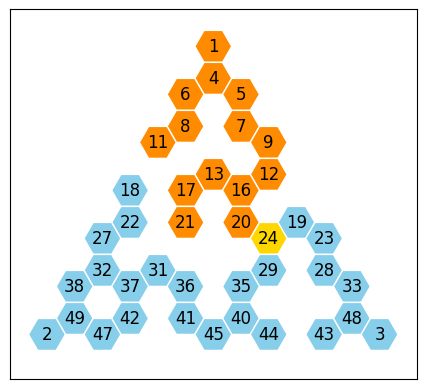

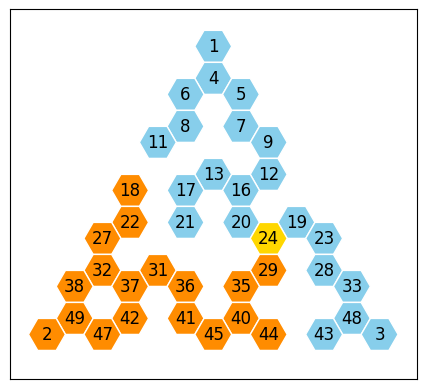

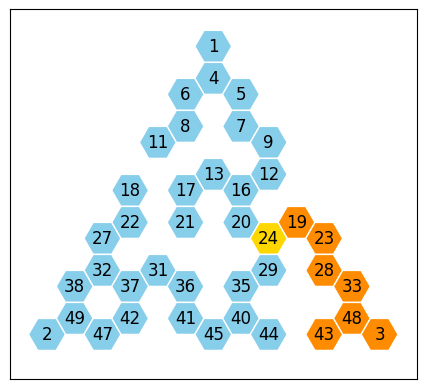

In [160]:
example_maze = {34, 39, 10, 14, 15, 46, 25, 26, 30}

thirds = divide_into_thirds(example_maze)
plot_hex_maze(example_maze, highlight_hexes=thirds[0], show_barriers=False)
plot_hex_maze(example_maze, highlight_hexes=thirds[1], show_barriers=False)
plot_hex_maze(example_maze, highlight_hexes=thirds[2], show_barriers=False)

hexes = get_hexes_within_distance(example_maze, 24, min_distance=1, max_distance=1)
# plot_hex_maze(example_maze, highlight_hexes=hexes, show_barriers=False)

In [162]:
# Convert to int so we can use groupby
# should be added to clean_session_df but whatever
df['session'] = df['session'].astype('int')
df['block'] = df['block'].astype('int')
df['tri'] = df['tri'].astype('float32')

# Initialize a dict to store info by trial_dict[session][block][trial]
trial_dict = {}

# First set up session and block level metadata
for session, session_df in df.groupby('session'):
    # Get the session type, rat, and date for this session
    session_type = session_df['session_type'].iloc[0]
    rat = session_df['rat'].iloc[0]
    date = session_df['date'].iloc[0]
    # If the date doesn't have a leading 0 and needs one, add it
    date = '0' + str(date) if not str(date)[0] in ('1', '0') else str(date)
    # Add session-level metadata (date, rat, session type)
    session_metadata = {'date': date, 'rat': rat, 'session_type': session_type}
    trial_dict[session] = {'metadata': session_metadata}
    # Load the barriers for all blocks in this session
    barrier_sequence = attempt_load_barriers(rat, date)
    for block, block_df in session_df.groupby('block'):
        # Get maze for this block from the barrier sequence
        maze = barrier_sequence[int(block)-1]
        # Divide the maze into 3 sections (between choice pt and each port)
        components = divide_into_thirds(maze)
        # Add block-level metadata (barriers, components, reward probabilities)
        block_metadata = {'barriers': maze,
                          'maze_components': components,
                          'nom_rwd_a': block_df['nom_rwd_a'].iloc[0],
                          'nom_rwd_b': block_df['nom_rwd_b'].iloc[0], 
                          'nom_rwd_c': block_df['nom_rwd_c'].iloc[0]}
        trial_dict[session][block] = {'metadata': block_metadata}

The given maze has 3 choice points: {25, 21, 31}
This function is not currently implemented for mazes with multiple choice points!
The choice point {20} does not split the maze into 3 distinct components!
The choice point {30} does not split the maze into 3 distinct components!
The given maze has 3 choice points: {25, 20, 13}
This function is not currently implemented for mazes with multiple choice points!
The given maze has 3 choice points: {8, 4, 7}
This function is not currently implemented for mazes with multiple choice points!
The given maze has 3 choice points: {25, 21, 31}
This function is not currently implemented for mazes with multiple choice points!
The given maze has 3 choice points: {35, 29, 39}
This function is not currently implemented for mazes with multiple choice points!


In [167]:
# What params do we want to use?
min_hexes_pre_choice = 1
max_hexes_pre_choice = 1
min_hexes_post_choice = 1
max_hexes_post_choice = 1
mua_thresh = 5
nonlocal_thresh = 0 # decode must be >30cm from rat to be considered nonlocal?
hpd_thresh = 800

# Get a subset of the df for a specific session, block, and trial
for (session, block, trial), trial_df in df.groupby(['session', 'block', 'tri']):

    # Get maze components for this trial
    barriers = trial_dict[session][block]['metadata']['barriers']
    maze_components = trial_dict[session][block]['metadata']['maze_components']
    # Skip all trials in blocks with mazes not good for our analysis (may change later)
    if maze_components is None:
        continue

    # If we passed the previous check, we only have a single choice point
    choice_point = get_critical_choice_points(barriers).pop()

    # Find each time the rat enters a new hex in this trial (Replace NaN with -1)
    hex_change_indices = np.where(trial_df['hexlabels'] != trial_df['hexlabels'].shift())[0]

    # Use these to get the rat's hex path for this trial as a list of ints
    hex_path = trial_df['hexlabels'].iloc[hex_change_indices].astype(int).tolist()
    # Remove all instances of -1 and remove hexes accidentally assigned to barriers
    hex_path = [hex for hex in hex_path if hex != -1 and hex not in barriers]

    # Add end index
    hex_change_indices = np.append(hex_change_indices, len(trial_df))

    # Map each hex in the maze to the maze component it belongs to (1, 2, or 3)
    mapping = {hex: i+1 for i, component in enumerate(maze_components) for hex in component}
    # Map choice point to 0
    mapping.update({choice_point: 0})

    # Map hexes in hex_path to the maze component they belong to
    maze_component = [mapping[hex] for hex in hex_path]

    # Get a condensed version of the path the rat took through the maze
    maze_path = remove_consecutive_duplicates(maze_component)

    # Get chosen/unchosen ports
    start_port = maze_path[0]
    end_port = maze_path[-1]
    unchosen_port = ({1, 2, 3} - {start_port, end_port}).pop()

    # Get chosen/unchosen reward probabilities
    reward_probs = [trial_dict[session][block]['metadata']['nom_rwd_a'],
                    trial_dict[session][block]['metadata']['nom_rwd_b'],
                    trial_dict[session][block]['metadata']['nom_rwd_c']]
    chosen_prob = float(reward_probs[end_port-1])
    unchosen_prob = float(reward_probs[unchosen_port-1])
    rwd_prob_difference = chosen_prob - unchosen_prob

    # Get chosen/unchosen path lengths
    chosen_path_length = get_hexes_from_port(barriers, start_port, end_port)+1
    unchosen_path_length = get_hexes_from_port(barriers, start_port, unchosen_port)+1
    path_length_difference = chosen_path_length - unchosen_path_length

    # For now, the rest of our analysis focuses on trials where the rat made
    # a choice at the choice point and stuck to it (never crossing back
    # through the choice point once it is crossed)
    if len(maze_path) == 3:
        start_component = maze_components[start_port-1]
        chosen_component = maze_components[end_port-1]
        unchosen_component = next(c for c in maze_components 
                                        if c != start_component 
                                        and c != chosen_component)

        pre_choice_hexes = start_component & get_hexes_within_distance(barriers, 
                                                                       choice_point, 
                                                                       min_distance=min_hexes_pre_choice,
                                                                       max_distance=max_hexes_pre_choice)
        chosen_hexes = chosen_component & get_hexes_within_distance(barriers, 
                                                                    choice_point, 
                                                                    min_distance=min_hexes_post_choice, 
                                                                    max_distance=max_hexes_post_choice)
        unchosen_hexes = unchosen_component & get_hexes_within_distance(barriers, 
                                                                        choice_point, 
                                                                        min_distance=min_hexes_post_choice, 
                                                                        max_distance=max_hexes_post_choice)
        
        # How long (in samples) are post-choice hex represented 
        # as the rat approaches the choice point?
        chosen_hex_reps = trial_df.loc[(trial_df['hexlabels'].isin(pre_choice_hexes)) &
                                       (trial_df['pred_hexlabels'].isin(chosen_hexes)) &
                                       (trial_df['decodeDistToRat'] > nonlocal_thresh) &
                                       (trial_df['mua'] > mua_thresh) &
                                       (trial_df['decodeHPD'] < hpd_thresh),
                                       'pred_hexlabels'].value_counts().to_dict()
        
        unchosen_hex_reps = trial_df.loc[(trial_df['hexlabels'].isin(pre_choice_hexes)) &
                                         (trial_df['pred_hexlabels'].isin(unchosen_hexes)) &
                                         (trial_df['decodeDistToRat'] > nonlocal_thresh) &
                                         (trial_df['mua'] > mua_thresh) &
                                         (trial_df['decodeHPD'] < hpd_thresh),
                                         'pred_hexlabels'].value_counts().to_dict()
    else:
        # For now, just have these be empty
        chosen_hex_reps = {}
        unchosen_hex_reps = {}
    
    # Add trial data to our dictionary
    trial_data = {'trial_length': len(trial_df)/250,
                  'hex_path': hex_path,
                  'maze_component': maze_component,
                  'maze_path': maze_path,
                  'start_port': start_port,
                  'end_port': end_port,
                  'unchosen_port': unchosen_port,
                  'chosen_hex_reps': chosen_hex_reps,
                  'unchosen_hex_reps': unchosen_hex_reps,
                  'total_chosen_reps': sum(chosen_hex_reps.values()),
                  'total_unchosen_reps': sum(unchosen_hex_reps.values()),
                  'chosen_prob': chosen_prob,
                  'unchosen_prob': unchosen_prob,
                  'rwd_prob_difference': rwd_prob_difference,
                  'chosen_path_length': chosen_path_length,
                  'unchosen_path_length': unchosen_path_length,
                  'path_length_difference': path_length_difference}
    trial_dict[session][block][trial] = trial_data

trial_df = nested_dict_to_df(trial_dict, metadata=True)
display(trial_df)

/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,session,block,trial,trial_length,hex_path,maze_component,maze_path,start_port,end_port,unchosen_port,...,unchosen_path_length,path_length_difference,date,rat,session_type,barriers,maze_components,nom_rwd_a,nom_rwd_b,nom_rwd_c
0,2,1,4,5.868,"[20, 16, 13, 17, 13, 16, 12, 9, 7, 5, 4, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[1],1,1,2,...,21,-20,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
1,2,1,5,24.508,"[1, 4, 5, 7, 12, 16, 20, 24, 29, 35, 40, 45, 4...","[1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, ...","[1, 0, 2]",1,2,3,...,15,6,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
2,2,1,6,31.212,"[2, 49, 47, 42, 37, 31, 36, 41, 45, 40, 35, 29...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, ...","[2, 0, 3]",2,3,1,...,21,-2,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
3,2,1,7,14.968,"[3, 48, 43, 48, 33, 28, 23, 19, 24, 20, 16, 12...","[3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1]","[3, 0, 1]",3,1,2,...,19,-4,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
4,2,1,8,25.976,"[1, 4, 5, 7, 12, 16, 20, 24, 29, 35, 40, 44, 4...","[1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, ...","[1, 0, 2]",1,2,3,...,15,6,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,10,3,30,21.960,"[3, 48, 3, 48, 43, 48, 43, 39, 43, 39, 43, 39,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 0, 1]",3,1,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0
1301,10,3,31,53.824,"[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 3]",1,3,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0
1302,10,3,32,9.656,"[3, 48, 33, 28, 23, 19, 24, 20, 16, 13, 10, 8,...","[3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1]","[3, 0, 1]",3,1,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0
1303,10,3,33,9.256,"[1, 4, 5, 7, 10, 13, 16, 20, 24, 19, 23, 28, 3...","[1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3]","[1, 0, 3]",1,3,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0


1 maze sections entered: 2
3 maze sections entered: 1104
5 maze sections entered: 100
11 maze sections entered: 16
9 maze sections entered: 14
4 maze sections entered: 1
6 maze sections entered: 3
7 maze sections entered: 42
2 maze sections entered: 3
12 maze sections entered: 1
19 maze sections entered: 2
15 maze sections entered: 7
13 maze sections entered: 3
47 maze sections entered: 1
17 maze sections entered: 3
23 maze sections entered: 1
67 maze sections entered: 1
49 maze sections entered: 1


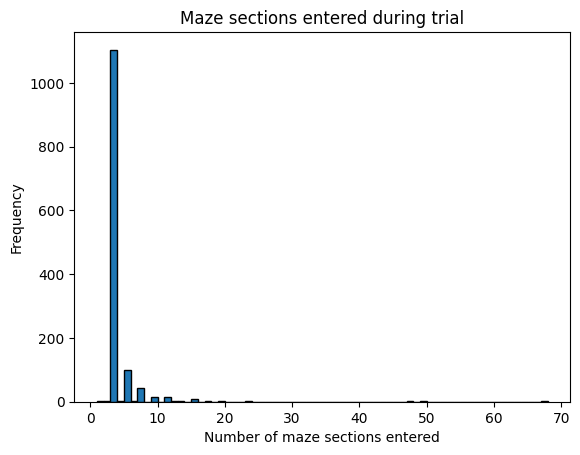

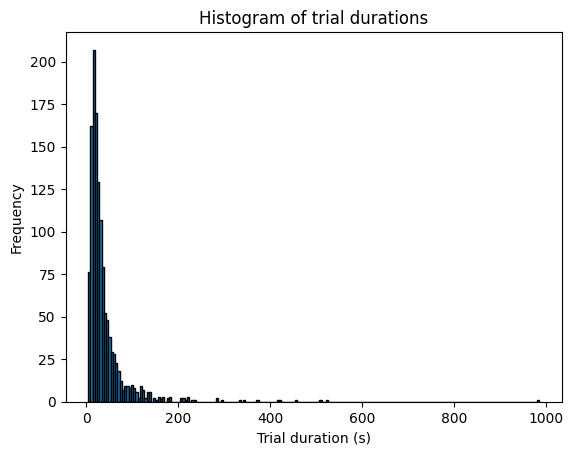

In [168]:
# What does the rat's average maze path look like?
path_lengths = trial_df['maze_path'].apply(len).tolist()
length_counts = Counter(path_lengths)

# Print each path length and its count
for length, count in length_counts.items():
    print(f"{length} maze sections entered: {count}")

# Histogram of how many maze sections a rat enters
plt.hist(path_lengths, bins=range(1, max(path_lengths) + 2), edgecolor='black')
plt.xlabel('Number of maze sections entered')
plt.ylabel('Frequency')
plt.title('Maze sections entered during trial')
plt.show()

# Histogram of trial durations
plt.hist(trial_df['trial_length'], bins='auto', edgecolor='black')
plt.xlabel('Trial duration (s)')
plt.ylabel('Frequency')
plt.title('Histogram of trial durations')
plt.show()

#fig, ax = plt.subplots(2, 1, figsize=(10, 12))
#ax[0].scatter(trial_df.index, trial_df['trial_length'])
#ax[1].scatter(trial_df.index, trial_df['maze_path'].apply(len).tolist())


/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/steph/berkelab/Hex-maze-analysis/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,session,block,trial,trial_length,hex_path,maze_component,maze_path,start_port,end_port,unchosen_port,...,unchosen_path_length,path_length_difference,date,rat,session_type,barriers,maze_components,nom_rwd_a,nom_rwd_b,nom_rwd_c
1,2,1,5,24.508,"[1, 4, 5, 7, 12, 16, 20, 24, 29, 35, 40, 45, 4...","[1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, ...","[1, 0, 2]",1,2,3,...,15,6,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
2,2,1,6,31.212,"[2, 49, 47, 42, 37, 31, 36, 41, 45, 40, 35, 29...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, ...","[2, 0, 3]",2,3,1,...,21,-2,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
3,2,1,7,14.968,"[3, 48, 43, 48, 33, 28, 23, 19, 24, 20, 16, 12...","[3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1]","[3, 0, 1]",3,1,2,...,19,-4,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
4,2,1,8,25.976,"[1, 4, 5, 7, 12, 16, 20, 24, 29, 35, 40, 44, 4...","[1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, ...","[1, 0, 2]",1,2,3,...,15,6,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
5,2,1,9,30.672,"[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 29...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, ...","[2, 0, 1]",2,1,3,...,19,2,07202022,IM-1478,prob,"{34, 39, 10, 14, 15, 46, 25, 26, 30}","[{1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 20,...",10.0,50.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,10,3,30,21.960,"[3, 48, 3, 48, 43, 48, 43, 39, 43, 39, 43, 39,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 0, 1]",3,1,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0
1301,10,3,31,53.824,"[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 3]",1,3,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0
1302,10,3,32,9.656,"[3, 48, 33, 28, 23, 19, 24, 20, 16, 13, 10, 8,...","[3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1]","[3, 0, 1]",3,1,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0
1303,10,3,33,9.256,"[1, 4, 5, 7, 10, 13, 16, 20, 24, 19, 23, 28, 3...","[1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3]","[1, 0, 3]",1,3,2,...,17,-2,07282023,IM-1594,barrier,"{32, 34, 35, 12, 45, 46, 15, 21, 26}","[{1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17,...",50.0,10.0,90.0


Mean chosen hex reps: 5.2898550724637685, std: 12.600250626269203
Mean unchosen hex reps: 3.9121376811594204, std: 10.58970562554911
T-statistic: 3.4869931485145957
P-value: 0.0005077147089078127


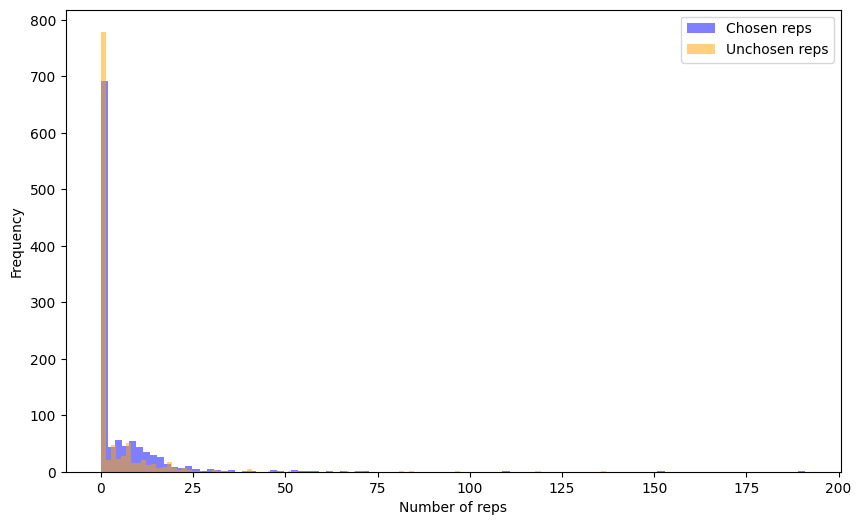

In [169]:
# Let's only look at the subset of the df useful for our analysis
reps_df = trial_df[trial_df['maze_path'].apply(len) == 3]
# Filter to the second half of a block?
# (Like Tim's paper, so the rat has time to adapt)
#reps_df = trial_df[trial_df['trial'] > 25]
display(reps_df)

print(f"Mean chosen hex reps: {reps_df['total_chosen_reps'].mean()}, std: {reps_df['total_chosen_reps'].std()}")
print(f"Mean unchosen hex reps: {reps_df['total_unchosen_reps'].mean()}, std: {reps_df['total_unchosen_reps'].std()}")

# Perform a paired t-test to see if the # of reps is statisticallly different
t_statistic, p_value = stats.ttest_rel(reps_df['total_chosen_reps'], reps_df['total_unchosen_reps'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Plot overlaid histograms
plt.figure(figsize=(10, 6))
plt.hist(reps_df['total_chosen_reps'], bins = 100, alpha=0.5, label='Chosen reps', color='blue')
plt.hist(reps_df['total_unchosen_reps'], bins = 100, alpha=0.5, label='Unchosen reps', color='orange')
plt.xlabel('Number of reps')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

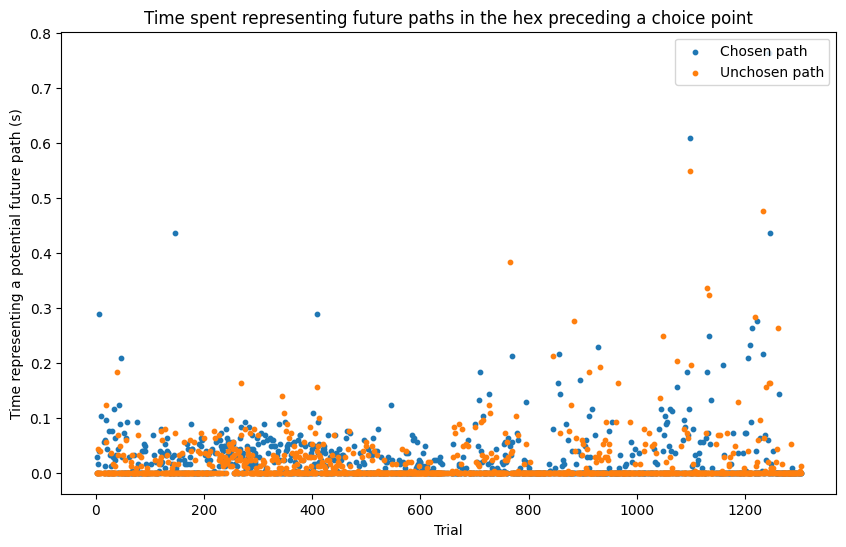

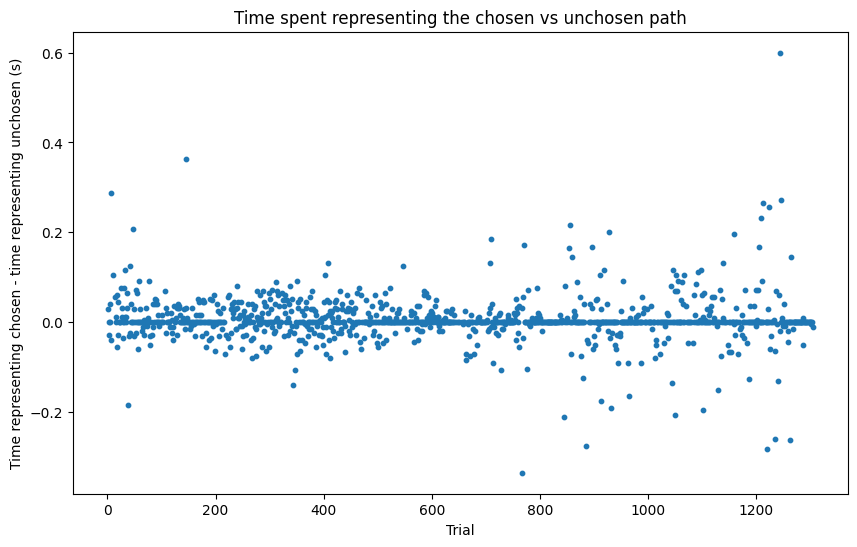

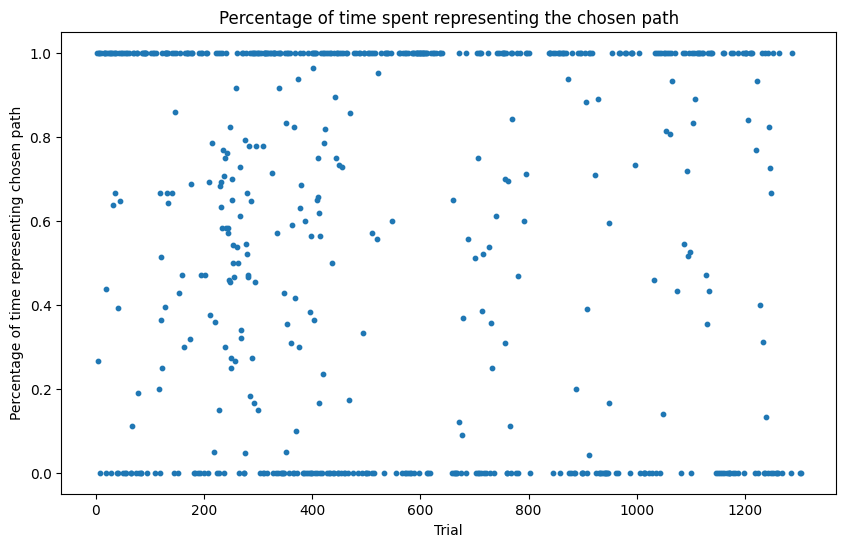

In [181]:
# Plot percentage of representations as a function of chosen vs unchosen
plt.figure(figsize=(10, 6))
plt.scatter(reps_df.index, reps_df['total_chosen_reps']/250, s=10, label='Chosen path')
plt.scatter(reps_df.index, reps_df['total_unchosen_reps']/250, s=10, label='Unchosen path')
plt.xlabel('Trial')
plt.ylabel('Time representing a potential future path (s)')
plt.title("Time spent representing future paths in the hex preceding a choice point")
plt.legend(loc='upper right')
plt.show()

# Time representing chosen - time representing unchosen
plt.figure(figsize=(10, 6))
plt.scatter(reps_df.index, (reps_df['total_chosen_reps']-reps_df['total_unchosen_reps'])/250, s=10)
plt.xlabel('Trial')
plt.ylabel('Time representing chosen - time representing unchosen (s)')
plt.title("Time spent representing the chosen vs unchosen path")
plt.show()

# Percentage of time representing chosen
plt.figure(figsize=(10, 6))
pct_chosen = reps_df['total_chosen_reps']/(reps_df['total_chosen_reps']+reps_df['total_unchosen_reps'])
plt.scatter(reps_df.index, pct_chosen, s=10)
plt.xlabel('Trial')
plt.ylabel('Percentage of time representing chosen path')
plt.title("Percentage of time spent representing the chosen path")
plt.show()

### Time spent representing future paths as a function of path "goodness" (reward probability difference and hex path length difference)

Are better paths represented more often?

Do harder decisions require more thinking?

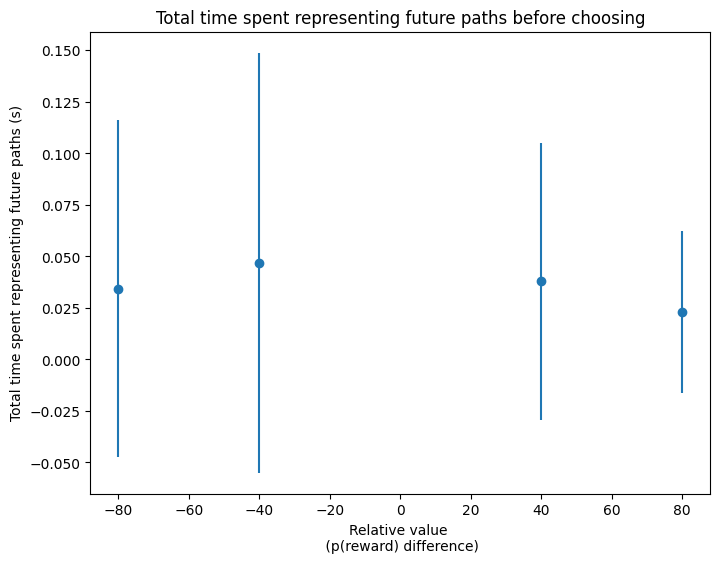

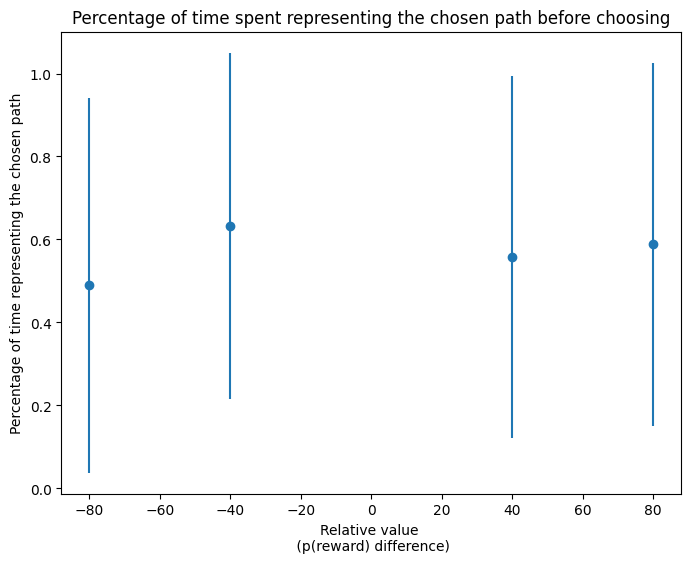

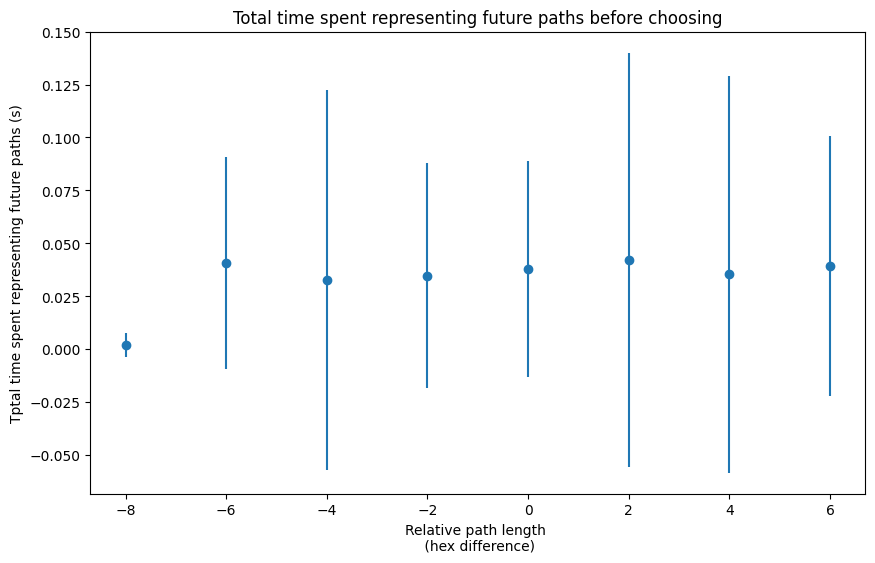

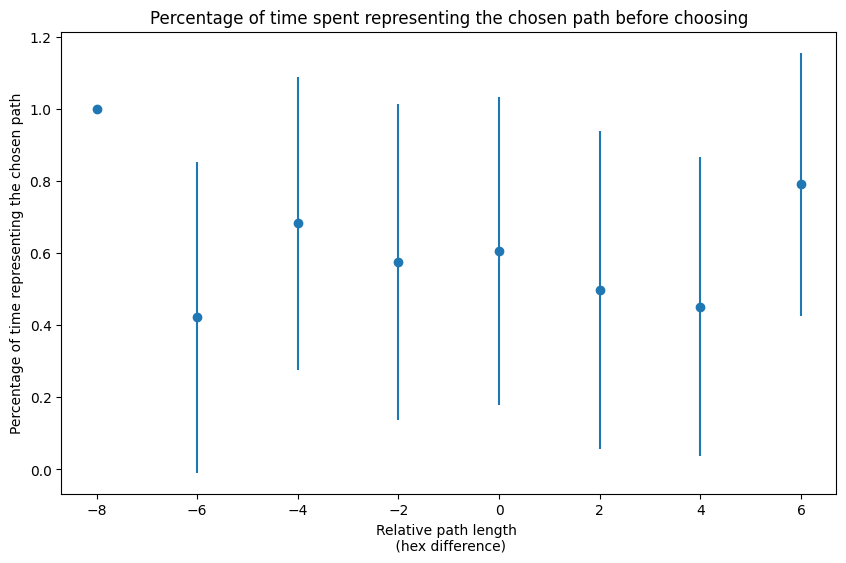

In [179]:
total_reps = reps_df['total_chosen_reps'] + reps_df['total_unchosen_reps']
chosen_pct_reps = reps_df['total_chosen_reps'] / total_reps

# Create a Dataframe so we can group things for plotting
plotting_df = pd.DataFrame({'time_repped': total_reps/250, 
                            'chosen_pct_reps': chosen_pct_reps,
                            'rwd_prob_diff': reps_df['rwd_prob_difference'],
                            'path_length_diff': reps_df['path_length_difference']})

# Time thinking vs difficulty of decision (reward prob)
grouped = plotting_df.groupby('rwd_prob_diff')['time_repped'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(8, 6))
plt.errorbar(grouped['rwd_prob_diff'], grouped['mean'], yerr=grouped['std'], fmt='o')
plt.xlabel('Relative value \n (p(reward) difference)')
plt.ylabel('Total time spent representing future paths (s)')
plt.title("Total time spent representing future paths before choosing")
plt.show()

# Same but percent time repping chosen
grouped = plotting_df.groupby('rwd_prob_diff')['chosen_pct_reps'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(8, 6))
plt.errorbar(grouped['rwd_prob_diff'], grouped['mean'], yerr=grouped['std'], fmt='o')
plt.xlabel('Relative value \n (p(reward) difference)')
plt.ylabel('Percentage of time representing the chosen path')
plt.title("Percentage of time spent representing the chosen path before choosing")
plt.show()

# Time thinking vs difficulty of decision (hex diff)
grouped = plotting_df.groupby('path_length_diff')['time_repped'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(10, 6))
plt.errorbar(grouped['path_length_diff'], grouped['mean'], yerr=grouped['std'], fmt='o')
plt.xlabel('Relative path length \n (hex difference)')
plt.ylabel('Tptal time spent representing future paths (s)')
plt.title("Total time spent representing future paths before choosing")
plt.show()

# Same but percent time repping chosen
grouped = plotting_df.groupby('path_length_diff')['chosen_pct_reps'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(10, 6))
plt.errorbar(grouped['path_length_diff'], grouped['mean'], yerr=grouped['std'], fmt='o')
plt.xlabel('Relative path length \n (hex difference)')
plt.ylabel('Percentage of time representing the chosen path')
plt.title("Percentage of time spent representing the chosen path before choosing")
plt.show()

### Same as above, but scatter plots

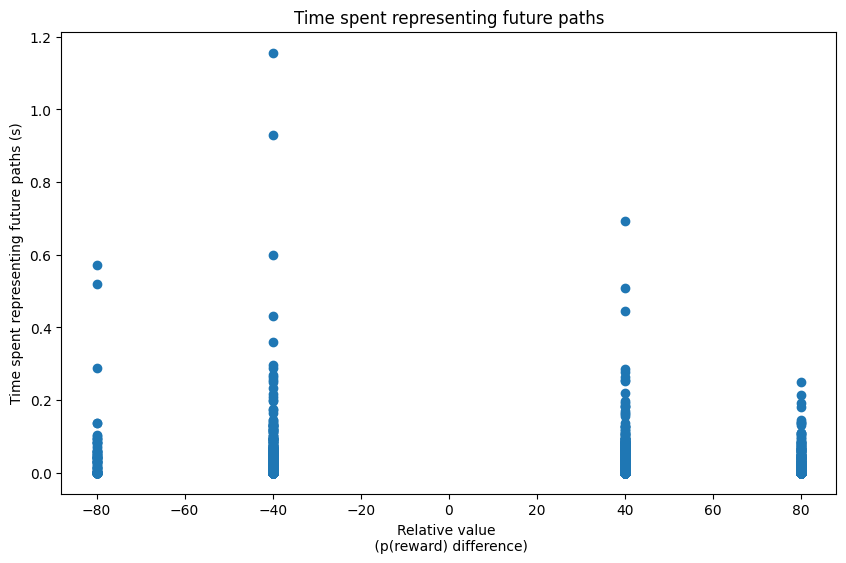

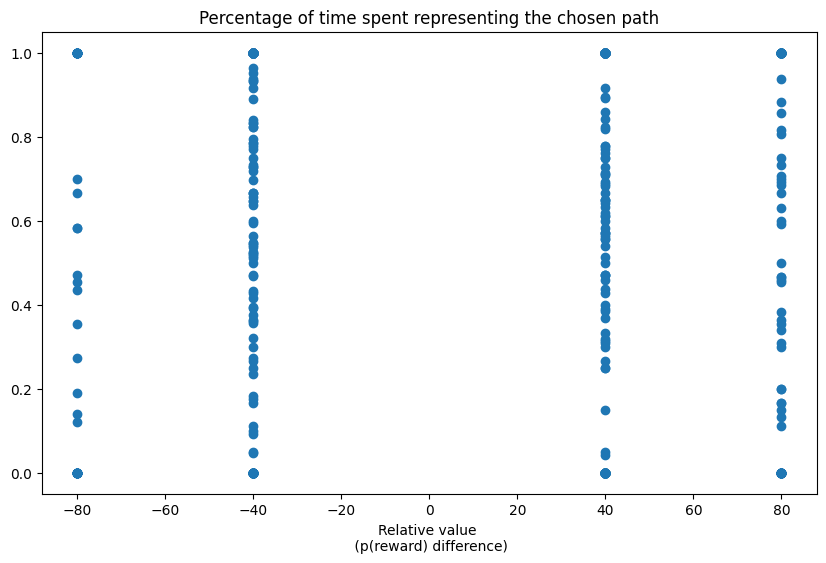

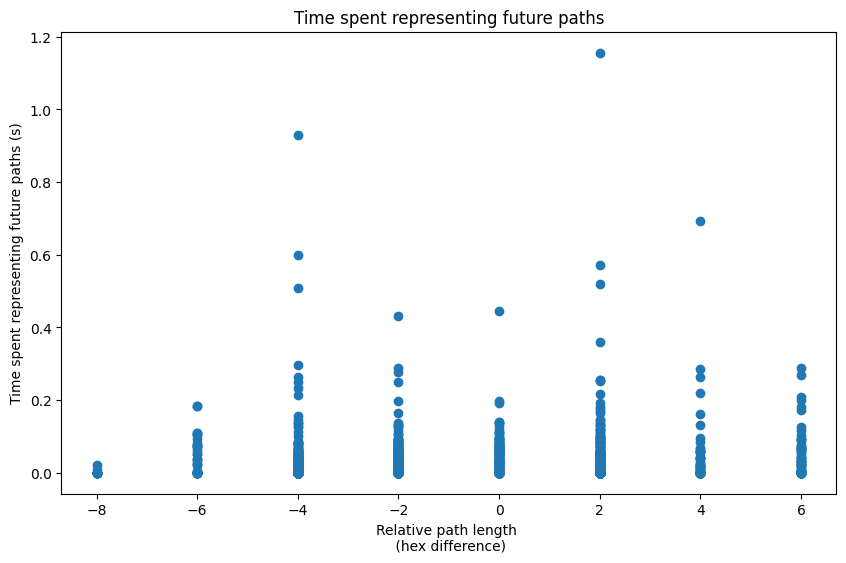

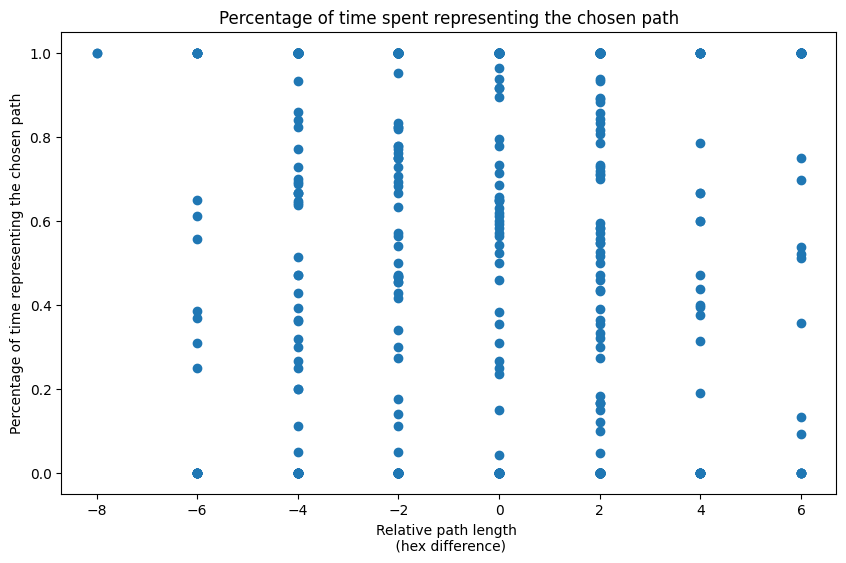

In [180]:
total_reps = reps_df['total_chosen_reps'] + reps_df['total_unchosen_reps']
chosen_pct_reps = reps_df['total_chosen_reps'] / total_reps

# Time thinking vs difficulty of decision (reward prob)
plt.figure(figsize=(10, 6))
plt.scatter(reps_df['rwd_prob_difference'], total_reps/250)
plt.xlabel('Relative value \n (p(reward) difference)')
plt.ylabel('Time spent representing future paths (s)')
plt.title("Time spent representing future paths")
plt.show()

# Same but percent time repping chosen
plt.figure(figsize=(10, 6))
plt.scatter(reps_df['rwd_prob_difference'], reps_df['total_chosen_reps']/total_reps )
plt.xlabel('Relative value \n (p(reward) difference)')
plt.ylabel('')
plt.title("Percentage of time spent representing the chosen path")
plt.show()

# Time thinking vs difficulty of decision (hex diff)
plt.figure(figsize=(10, 6))
plt.scatter(reps_df['path_length_difference'], total_reps/250)
plt.xlabel('Relative path length \n (hex difference)')
plt.ylabel('Time spent representing future paths (s)')
plt.title("Time spent representing future paths")
plt.show()

# Same but percent time repping chosen
plt.figure(figsize=(10, 6))
plt.scatter(reps_df['path_length_difference'], reps_df['total_chosen_reps']/total_reps )
plt.xlabel('Relative path length \n (hex difference)')
plt.ylabel('Percentage of time representing the chosen path')
plt.title("Percentage of time spent representing the chosen path")
plt.show()